# Line 3 Dfit
Fitting of a TGraph2D with a 3D straight line

run this macro by doing:

```cpp
root>.x line3Dfit.C+
```




**Author:** Lorenzo Moneta  
<i><small>This notebook tutorial was automatically generated with <a href= "https://github.com/root-project/root/blob/master/documentation/doxygen/converttonotebook.py">ROOTBOOK-izer</a> from the macro found in the ROOT repository  on Thursday, August 29, 2019 at 01:31 AM.</small></i>

In [1]:
%%cpp -d
#include <TMath.h>
#include <TGraph2D.h>
#include <TRandom2.h>
#include <TStyle.h>
#include <TCanvas.h>
#include <TF2.h>
#include <TH1.h>
#include <Math/Functor.h>
#include <TPolyLine3D.h>
#include <Math/Vector3D.h>
#include <Fit/Fitter.h>

#include <cassert>

In [2]:
%%cpp -d
// This is a workaround to make sure the namespace is used inside functions
using namespace ROOT::Math;

In [3]:
bool first = true;

Function object to be minimized

In [4]:
struct SumDistance2 {
   // the TGraph is a data member of the object
   TGraph2D *fGraph;

   SumDistance2(TGraph2D *g) : fGraph(g) {}

   // calculate distance line-point
   double distance2(double x,double y,double z, const double *p) {
      // distance line point is D= | (xp-x0) cross  ux |
      // where ux is direction of line and x0 is a point in the line (like t = 0)
      XYZVector xp(x,y,z);
      XYZVector x0(p[0], p[2], 0. );
      XYZVector x1(p[0] + p[1], p[2] + p[3], 1. );
      XYZVector u = (x1-x0).Unit();
      double d2 = ((xp-x0).Cross(u)).Mag2();
      return d2;
   }

   // implementation of the function to be minimized
   double operator() (const double *par) {
      assert(fGraph != 0);
      double * x = fGraph->GetX();
      double * y = fGraph->GetY();
      double * z = fGraph->GetZ();
      int npoints = fGraph->GetN();
      double sum = 0;
      for (int i  = 0; i < npoints; ++i) {
         double d = distance2(x[i],y[i],z[i],par);
         sum += d;
      }
      if (first) {
         std::cout << "Total Initial distance square = " << sum << std::endl;
      }
      first = false;
      return sum;
   }

};

  define the parametric line equation
 

In [5]:
%%cpp -d
void line(double t, const double *p, double &x, double &y, double &z) {
   // a parametric line is define from 6 parameters but 4 are independent
   // x0,y0,z0,z1,y1,z1 which are the coordinates of two points on the line
   // can choose z0 = 0 if line not parallel to x-y plane and z1 = 1;
   x = p[0] + p[1]*t;
   y = p[2] + p[3]*t;
   z = t;
}

In [6]:
gStyle->SetOptStat(0);
gStyle->SetOptFit();

Double e = 0.1;

In [7]:
Int_t nd = 10000;

Double xmin = 0; double ymin = 0;
 double xmax = 10; double ymax = 10;

In [8]:
TGraph2D * gr = new TGraph2D();

Fill the 2d graph

In [9]:
double p0[4] = {10,20,1,2};

Generate graph with the 3d points

In [10]:
for (Int_t N=0; N<nd; N++) {
   double x,y,z = 0;
   // Generate a random number
   double t = gRandom->Uniform(0,10);
   line(t,p0,x,y,z);
   double err = 1;
   // do a gaussian smearing around the points in all coordinates
   x += gRandom->Gaus(0,err);
   y += gRandom->Gaus(0,err);
   z += gRandom->Gaus(0,err);
   gr->SetPoint(N,x,y,z);
   //dt->SetPointError(N,0,0,err);
}

Fit the graph now

In [11]:
ROOT::Fit::Fitter  fitter;

Make the functor objet

In [12]:
SumDistance2 sdist(gr);
ROOT::Math::Functor fcn(sdist,4);

Set the function and the initial parameter values

In [13]:
double pStart[4] = {1,1,1,1};
fitter.SetFCN(fcn,pStart);

Set step sizes different than default ones (0.3 times parameter values)

In [14]:
for (int i = 0; i < 4; ++i) fitter.Config().ParSettings(i).SetStepSize(0.01);

bool ok = fitter.FitFCN();
if (!ok) {
   Error("line3Dfit","Line3D Fit failed");
   return 1;
}

const ROOT::Fit::FitResult & result = fitter.Result();

std::cout << "Total final distance square " << result.MinFcnValue() << std::endl;
result.Print(std::cout);


gr->Draw("p0");

Total Initial distance square = 8.65172e+07
Total final distance square 19988

****************************************
Minimizer is Minuit / Migrad
MinFCN                    =        19988
NDf                       =            0
Edm                       =  6.31385e-10
NCalls                    =          257
Par_0                     =      10.3552   +/-   0.39454     
Par_1                     =      19.9602   +/-   0.0689483   
Par_2                     =     0.999198   +/-   0.0444211   
Par_3                     =      2.00379   +/-   0.00780946  


Info in <TCanvas::MakeDefCanvas>:  created default TCanvas with name c1


Get fit parameters

In [15]:
const double * parFit = result.GetParams();

Draw the fitted line

In [16]:
int n = 1000;
double t0 = 0;
double dt = 10;
TPolyLine3D *l = new TPolyLine3D(n);
for (int i = 0; i <n;++i) {
   double t = t0+ dt*i/n;
   double x,y,z;
   line(t,parFit,x,y,z);
   l->SetPoint(i,x,y,z);
}
l->SetLineColor(kRed);
l->Draw("same");

Draw original line

In [17]:
TPolyLine3D *l0 = new TPolyLine3D(n);
for (int i = 0; i <n;++i) {
   double t = t0+ dt*i/n;
   double x,y,z;
   line(t,p0,x,y,z);
   l0->SetPoint(i,x,y,z);
}
l0->SetLineColor(kBlue);
l0->Draw("same");
return 0;

Draw all canvases 

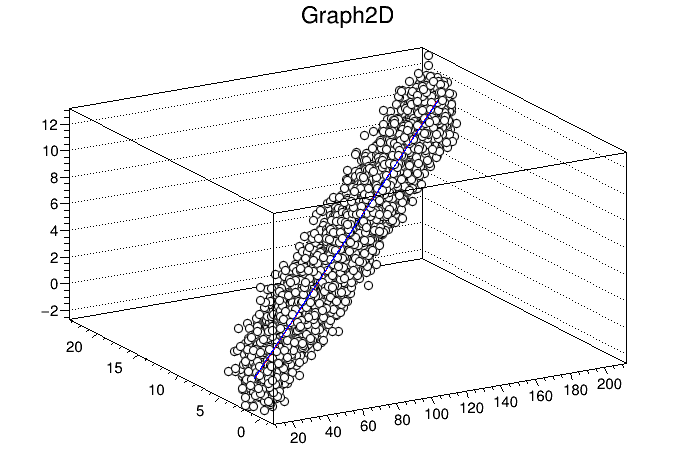

In [18]:
gROOT->GetListOfCanvases()->Draw()